In [17]:
# Install required libraries
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev
!pip install pytesseract opencv-python numpy pandas matplotlib scikit-learn tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 3,743 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.5 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB

In [18]:
# Import libraries
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import string
import pandas as pd

In [19]:
# Function to upload image
def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f'Uploaded {filename}')
        return filename
    return None

In [20]:
# Function to preprocess image for OCR
def preprocess_image(image_path):
    # Read image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply noise reduction
    denoised = cv2.fastNlMeansDenoising(gray)

    # Apply threshold to get binary image
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply dilation to make text more visible
    kernel = np.ones((1, 1), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=1)

    # Display original and processed images
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(binary, cmap='gray')
    plt.title('Binary Image')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(dilated, cmap='gray')
    plt.title('Processed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return dilated, image

In [21]:
# Function to extract text using Tesseract OCR
def extract_text_with_ocr(image):
    # Use Tesseract to extract text
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(image, config=custom_config)

    # Extract words and their bounding boxes
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

    return text, data

In [22]:
# Function to draw bounding boxes around text
def draw_text_boxes(image, data):
    output_image = image.copy()
    n_boxes = len(data['text'])

    for i in range(n_boxes):
        if int(data['conf'][i]) > 30:  # Confidence threshold
            (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title('Text Detection with Bounding Boxes')
    plt.axis('off')
    plt.show()

    return output_image

In [23]:
# Function to create synthetic dataset for training
def create_synthetic_dataset(num_samples=1000):
    # Define characters to use
    characters = string.ascii_letters + string.digits

    # Create empty lists for data and labels
    images = []
    labels = []

    # Font settings
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN,
             cv2.FONT_HERSHEY_DUPLEX, cv2.FONT_HERSHEY_COMPLEX]

    for i in range(num_samples):
        # Create a blank image
        img = np.zeros((32, 32, 3), dtype=np.uint8)

        # Randomly select a character
        char = np.random.choice(list(characters))

        # Randomly select font and scale
        font = np.random.choice(fonts)
        font_scale = np.random.uniform(0.5, 1.5)

        # Get text size
        text_size = cv2.getTextSize(char, font, font_scale, 2)[0]

        # Calculate position to center text
        x = (32 - text_size[0]) // 2
        y = (32 + text_size[1]) // 2

        # Add text to image
        cv2.putText(img, char, (x, y), font, font_scale, (255, 255, 255), 2)

        # Apply random transformations
        # Noise
        noise = np.random.randint(0, 50, (32, 32, 3), dtype=np.uint8)
        img = cv2.add(img, noise)

        # Blur
        if np.random.random() > 0.5:
            img = cv2.GaussianBlur(img, (3, 3), 0)

        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Normalize
        img_gray = img_gray / 255.0

        # Add to dataset
        images.append(img_gray)
        labels.append(char)

    return np.array(images), np.array(labels)

In [24]:
# Function to build and train character recognition model
def build_and_train_model(X, y):
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Reshape data for CNN
    X_reshaped = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_reshaped, y_categorical, test_size=0.2, random_state=42
    )

    # Build model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train,
                        epochs=10,
                        validation_data=(X_test, y_test),
                        batch_size=32,
                        verbose=1)

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, label_encoder

In [25]:
# Function to recognize characters using our trained model
def recognize_characters(model, label_encoder, image, data):
    recognized_text = ""

    n_boxes = len(data['text'])
    for i in range(n_boxes):
        if int(data['conf'][i]) > 30:  # Confidence threshold
            (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])

            # Extract character region
            char_region = image[y:y+h, x:x+w]

            # Resize to 32x32
            char_resized = cv2.resize(char_region, (32, 32))

            # Normalize
            char_normalized = char_resized / 255.0

            # Reshape for model input
            char_input = char_normalized.reshape(1, 32, 32, 1)

            # Predict
            prediction = model.predict(char_input, verbose=0)
            predicted_char = label_encoder.inverse_transform([np.argmax(prediction)])[0]

            recognized_text += predicted_char

    return recognized_text

In [10]:
# Main execution
print("Please upload an image containing text...")
image_path = upload_image()

Please upload an image containing text...


Saving download.png to download.png
Uploaded download.png
Please upload an image containing text...


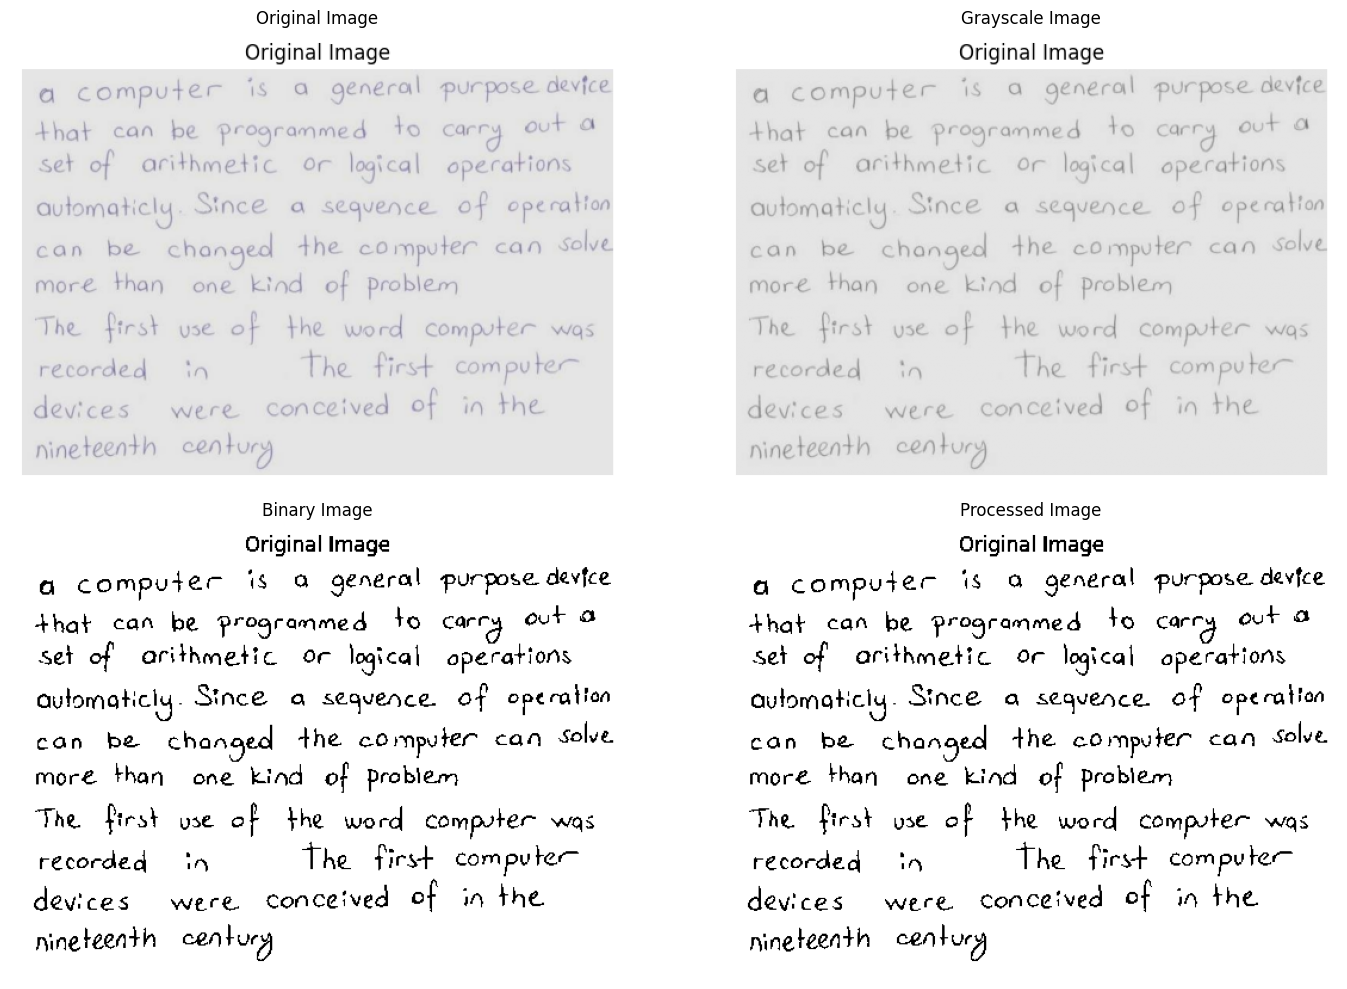

In [11]:
# Preprocess image
processed_image, original_image = preprocess_image(image_path)

In [12]:
# Extract text with OCR
extracted_text, text_data = extract_text_with_ocr(processed_image)
print("=" * 50)
print("TEXT EXTRACTED BY TESSERACT OCR:")
print("=" * 50)
print(extracted_text)

TEXT EXTRACTED BY TESSERACT OCR:
Original Image
a computer is 2 general purpose device
that can be programmed to carry out o
set of arithmetic or logical operations
automaticly Since a sequence. of operation
can be changed the computer can solve,
more than one kind of problem
The first use of the word computer was
recorded in The first computer
devices were conceived of in the
nineteenth century



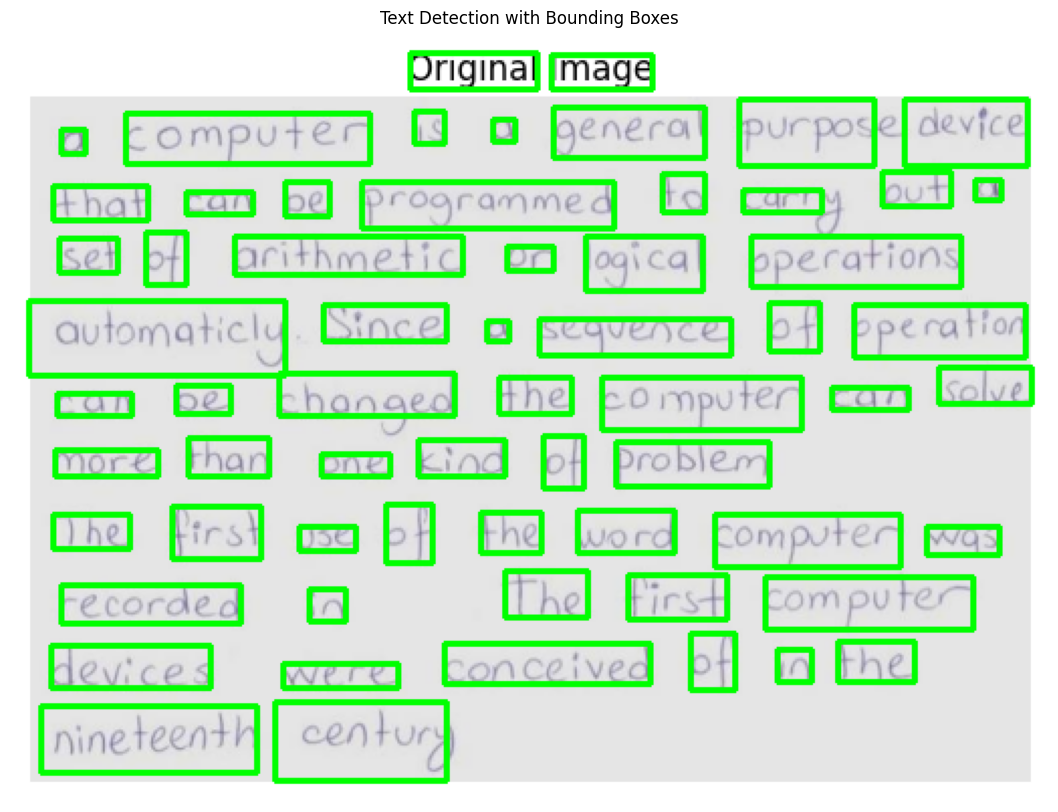

Creating synthetic dataset and training character recognition model...


In [13]:
# Draw bounding boxes
annotated_image = draw_text_boxes(original_image, text_data)

# Create synthetic dataset and train model
print("Creating synthetic dataset and training character recognition model...")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.0611 - loss: 3.9570 - val_accuracy: 0.5470 - val_loss: 1.9005
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.3926 - loss: 2.1470 - val_accuracy: 0.7730 - val_loss: 0.8560
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6045 - loss: 1.2825 - val_accuracy: 0.8260 - val_loss: 0.5837
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6885 - loss: 0.9518 - val_accuracy: 0.8670 - val_loss: 0.4523
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7632 - loss: 0.7208 - val_accuracy: 0.8780 - val_loss: 0.3805
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7855 - loss: 0.6261 - val_accuracy: 0.8950 - val_loss: 0.3297
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8069 - loss: 0.5582 - val_accuracy: 0.9010 - val_loss: 0.3038
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8152 - loss: 0.5207 - val_acc

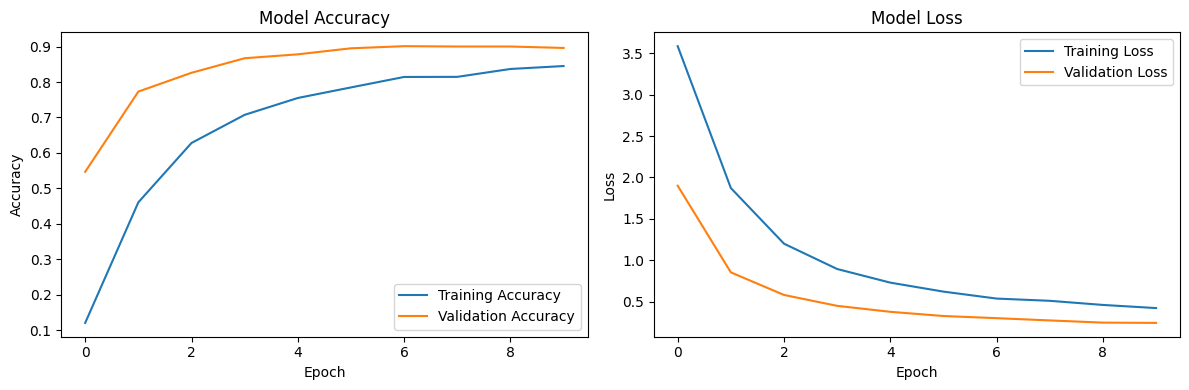

In [14]:
X, y = create_synthetic_dataset(5000)  # Create 5000 samples
model, label_encoder = build_and_train_model(X, y)

In [15]:
# Recognize characters using our model
print("Recognizing characters with trained model...")
custom_recognized_text = recognize_characters(model, label_encoder, processed_image, text_data)

print("=" * 50)
print("TEXT RECOGNIZED BY TRAINED MODEL:")
print("=" * 50)
print(custom_recognized_text)

Recognizing characters with trained model...
TEXT RECOGNIZED BY TRAINED MODEL:
FEEfmeJZ7mUm7rUWCr4UTZEtVWZZZUYmmyNxMkZmdVNQV4lmTUQFDkCMMm4mlC2


In [16]:
# Compare results
print("=" * 50)
print("COMPARISON:")
print("=" * 50)
print("Tesseract OCR:")
print(extracted_text)
print("\nTrained Model:")
print(custom_recognized_text)

COMPARISON:
Tesseract OCR:
Original Image
a computer is 2 general purpose device
that can be programmed to carry out o
set of arithmetic or logical operations
automaticly Since a sequence. of operation
can be changed the computer can solve,
more than one kind of problem
The first use of the word computer was
recorded in The first computer
devices were conceived of in the
nineteenth century


Trained Model:
FEEfmeJZ7mUm7rUWCr4UTZEtVWZZZUYmmyNxMkZmdVNQV4lmTUQFDkCMMm4mlC2
